## Measurements Quality Assessments using data from the Solcast API
In this real-world example we are going to use Historic data from the Solcast API to perform quality assurance on some measurement data. The measurements data used in the exercise is a re-worked time-series sourced from the Goodwin Creek Mississippi SURFRAD site. For an example on how to source measurement data from SURFRAD, check the `Comparing Solcast API data with Surfrad measurements.ipynb` example. 

We will be using some external libraries for this task, in particular [Pvanalytics](https://pvanalytics.readthedocs.io/en/stable/), an industry standard when it comes to PV analytics, and [Plotly](https://plotly.com/python/), a common Python plotting library.

In [1]:
#!pip install plotly pvanalytics

In [3]:
import pandas as pd
import plotly.express as plx
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from pvanalytics import quality
from typing import List
pio.renderers.default = "png"

> To allow interactivity of the plots produced, remove the setting `pio.renderers.default = "png"` 

Let's load a set of measurements, roughly a month of GHI, and retrieve the same time-series from the Solcast API with `solcast.historic.radiation_and_weather`

In [4]:
measurements = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)

In [5]:
# retrieve relevant Solcast data
from solcast import historic

# NOTE: this will consume an API request!
solcast = historic.radiation_and_weather(
    latitude=34.2547,
    longitude=-89.8729,
    output_parameters=['ghi', 'clearsky_ghi', 'zenith'],
    start=measurements.index.min(),
    end=measurements.index.max(),
    period='PT5M',
    timezone="-5"
)

solcast = solcast.to_pandas()
solcast.index.name = "period_end[UTC-5]"

df = solcast.join(measurements, lsuffix='_solcast', rsuffix='_surfrad', how='left')

## Filter on azimuth
We are going to evaluate the time series only when we are sure that the sun is above the horizon, so the first step in our QC will be to set measurement values to zero when the zenith, retrieve from the Solcast API above, is less than 88 degrees.

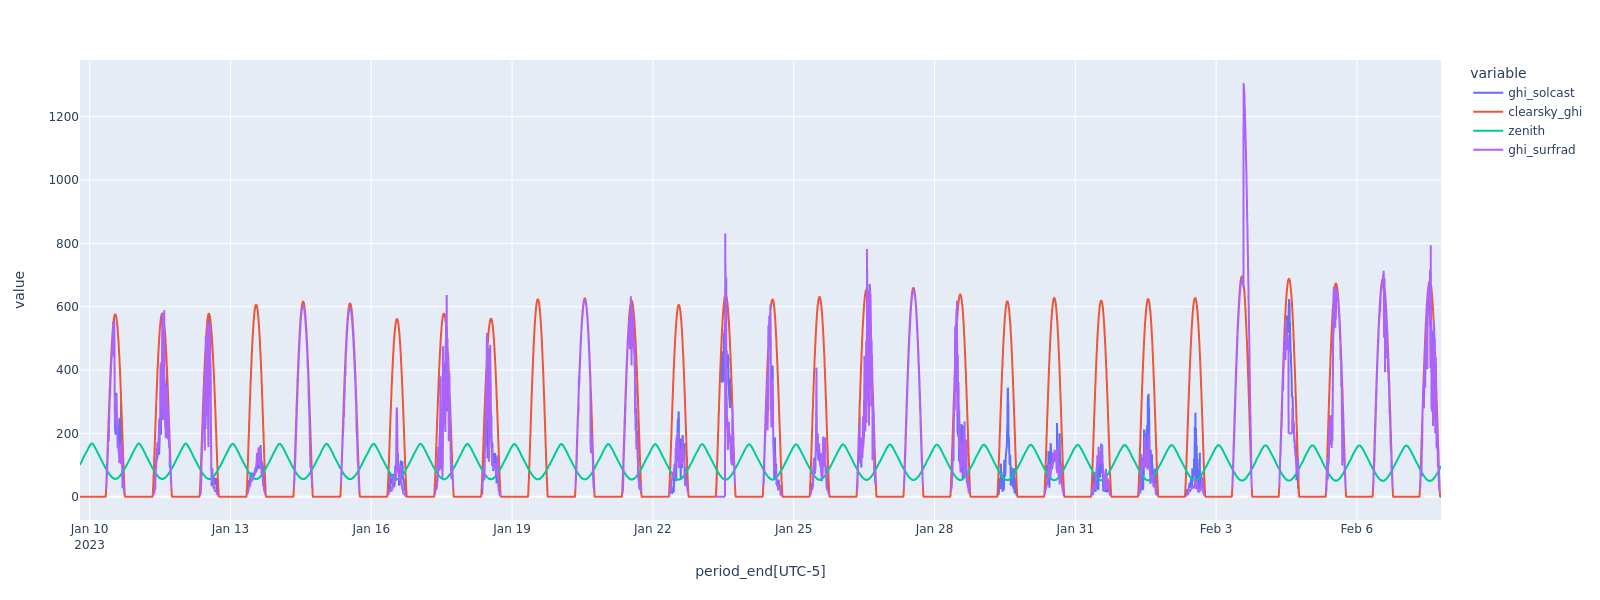

In [9]:
df.loc[df.zenith>=88, ['ghi_surfrad', 'ghi_solcast']] = None

fig = make_subplots()
fig = plx.line(df)
fig.update_layout(
    autosize=False,
    width=1600,
    height=600
)

## Missing and Stale data
A common issue with measurement data is to have an incomplete time series with missing or stale data. We can identify gaps and stale sequences in our data using pvanalytics' [quality.gaps.complete](https://pvanalytics.readthedocs.io/en/stable/generated/pvanalytics.quality.gaps.complete.html) and [quality.gaps.stale_values_diff](https://pvanalytics.readthedocs.io/en/stable/generated/pvanalytics.quality.gaps.stale_values_diff.html). Once identified we can fill or replace their values with Solcast API's Historial actuals.

In [10]:
def missing_and_stale(values: pd.Series) -> List:
    """returns true for values that are missing or stale in the timeseries. """
    complete = quality.gaps.complete(values)
    stale = quality.gaps.stale_values_diff(values, mark='all')     
    return (~complete | stale)

df['incomplete_or_stale'] = missing_and_stale(df.ghi_surfrad)
df.loc[df.incomplete_or_stale==True, 'ghi_processed'] = df['ghi_solcast']
df.loc[df.incomplete_or_stale==False, 'ghi_processed'] = df['ghi_surfrad']

Let's plot the results. The dashed line represents where we filled missing measurement data with Solcast's Historical data.

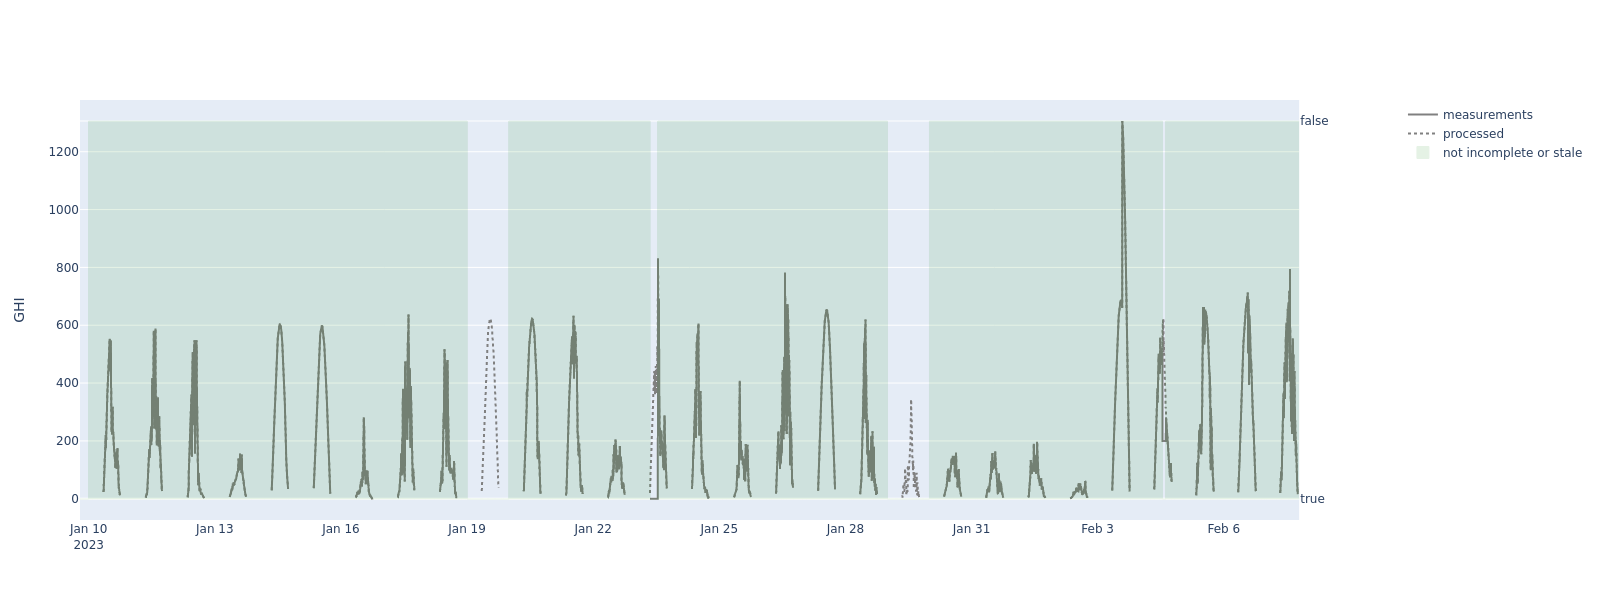

In [11]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df.index, y=df.ghi_surfrad, name="measurements", marker=dict(color='grey')),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df.index, y=df.ghi_processed, name="processed", marker=dict(color='grey'), line=dict(dash='dot')),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(
        x=df.index, 
        y=df.incomplete_or_stale, 
        name="not incomplete or stale", 
        marker_line_width=1, 
        marker_color='green',
        marker_line_color='green',
        opacity=0.1
    ),
    secondary_y=True,
)

fig.update_layout(
    autosize=False,
    width=1600,
    height=600
)
fig.update_yaxes(title_text="GHI", secondary_y=False)
fig.show()

### Non-physical values
We can perform a basic test for physical plausibility of irradiance measurements using the zenith, by making sure that whenever we are in full daylight, let's say with `zenith` angles < 84 degress, the GHI is greather than 0.

> For more thorough physical checks you can look into `pvanalytics` [quality.irradiance.check_ghi_limits_qcrad](https://pvanalytics.readthedocs.io/en/stable/generated/pvanalytics.quality.irradiance.check_ghi_limits_qcrad.html#pvanalytics.quality.irradiance.check_ghi_limits_qcrad)

In [12]:
def positive_in_daylight(values: pd.Series, zenith: pd.Series, daylight: int=84) -> List:
    return [False if ((z < daylight) & (v <= 0)) else True for z, v in zip(zenith, values)]

df['physical'] = positive_in_daylight(df.ghi_surfrad, df.zenith)
df.loc[df.physical == False, 'ghi_processed'] = df['ghi_solcast']
df.loc[df.physical == True, 'ghi_processed'] = df['ghi_surfrad']

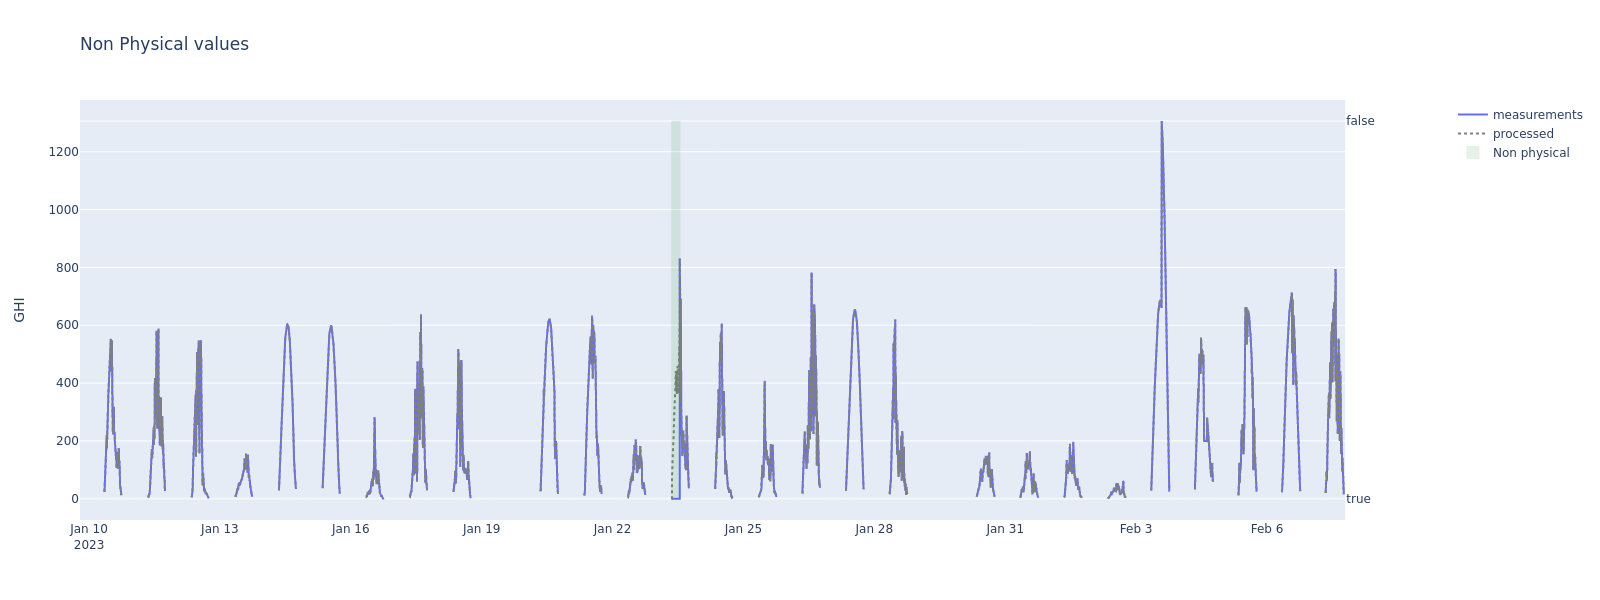

In [13]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df.index, y=df.ghi_surfrad, name="measurements"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(
        x=df.index, y=df.ghi_processed, name="processed", marker=dict(color='grey'), line=dict(dash='dot')
    ),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(
        x=df.index, 
        y=df.physical, 
        name="Non physical", 
        marker_line_width=1, 
        marker_color='green',
        marker_line_color='green',
        opacity=0.1
    ),
    secondary_y=True,
)

fig.update_layout(
    title_text="Non Physical values",
    autosize=False,
    width=1600,
    height=600,
)
fig.update_yaxes(title_text="GHI", secondary_y=False)
fig.show()

### Clearsky Index
A common way to flag anomalous values is to check for values that exceed the clearsky values. We will use the [clearsky_limits](https://pvanalytics.readthedocs.io/en/stable/generated/pvanalytics.quality.irradiance.clearsky_limits.html#pvanalytics.quality.irradiance.clearsky_limits) function from `pvanalytics` with clearsky values from the Solcast API.

In [14]:
df['clearsky_limits'] = quality.irradiance.clearsky_limits(
    df.ghi_surfrad, 
    df.clearsky_ghi
)

Let's plot the results to see where we have flagged values 

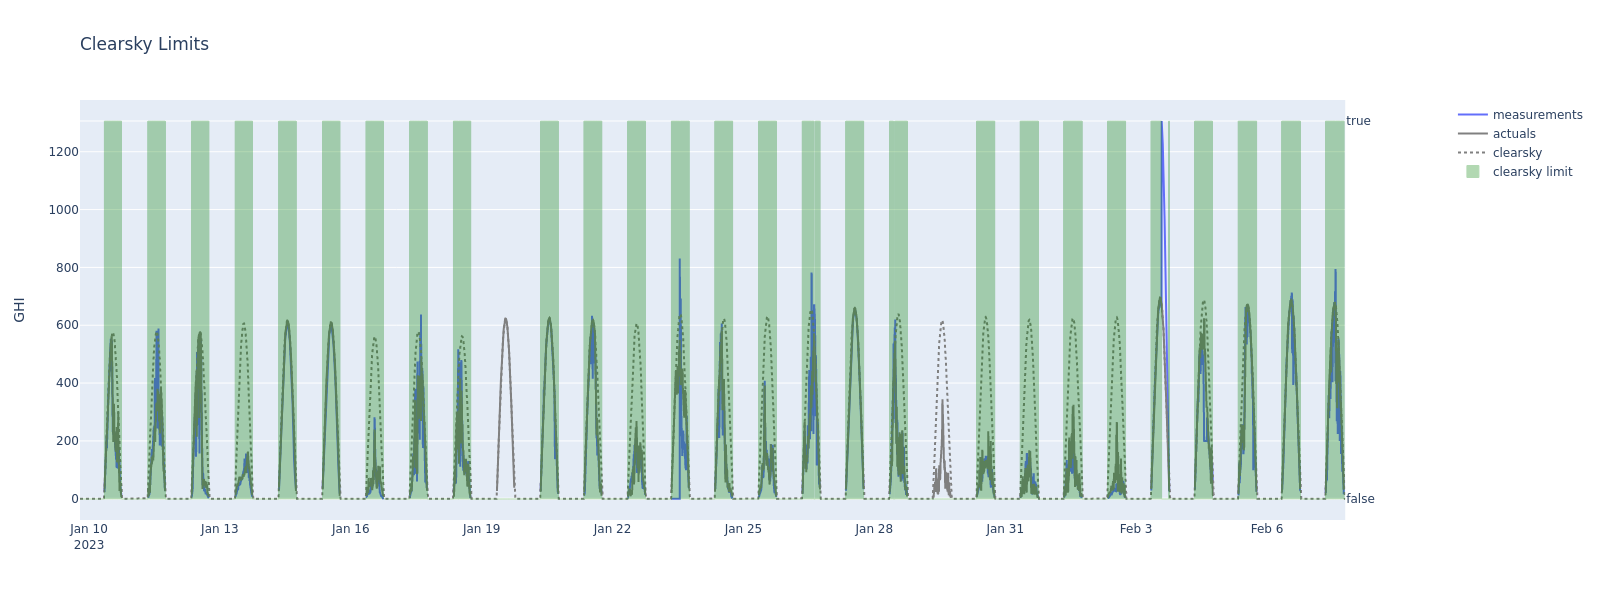

In [15]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df.index, y=df.ghi_surfrad, name="measurements"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df.index, y=df.ghi_solcast, name="actuals", marker=dict(color='grey')),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(
        x=df.index, y=df.clearsky_ghi, name="clearsky", marker=dict(color='grey'), line=dict(dash='dot')
    ),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(
        x=df.index, 
        y=df.clearsky_limits, 
        name="clearsky limit", 
        marker_line_width=1, 
        opacity=0.3, 
        marker_color='green',
        marker_line_color='green'
    ),
    secondary_y=True,
)

fig.update_layout(
    title_text="Clearsky Limits",
    autosize=False,
    width=1600,
    height=600,
)
fig.update_yaxes(title_text="GHI", secondary_y=False)
fig.show()

### Time zone check
another common issue with measurement data is whether the Time Zone is correctly defined. With the function below we identify at what time of day is peak irradiance. We can use this to spot differences between the measurement's peak irradiance vs Solcast's actuals to spot any possible issues with time zone. 

In [16]:
def hour_peak(df):
    """ resamples the time series to hourly to find the hour of day with peak irradiance"""
    #resample both timeseries to hourly
    df = df.resample('60Min').mean()
    #take mean grouped by hour of day
    df = df.groupby(df.index.hour).mean()
    #calculate hours of difference between hour of max mean in each timeseries
    print('hour of day with maximum irradiance: ', df[df.ghi==df.ghi.max()].index.values[0])

hour_peak(measurements)
hour_peak(solcast)

hour of day with maximum irradiance:  13
hour of day with maximum irradiance:  13


let's shift the measurement data by one hour. The peark irradiance now will be at 12, one hour before!

In [17]:
tmp = measurements.copy()
tmp.index = tmp.index - pd.to_timedelta(1, 'hour')
hour_peak(tmp)

hour of day with maximum irradiance:  12
